In [88]:
%matplotlib inline
import numpy as np
import keras
import tensorflow as tf

def convert_model(file_name):
    data = [x.rstrip() for x in open(file_name).read().split("\n")]
    
    #print(data)
    
    reverse_complement = int(data[1].split(" = ")[1])
    num_detectors = int(data[2].split(" = ")[1])
    detector_len = int(data[3].split(" = ")[1])
    has_avg_pooling = int(data[4].split(" = ")[1])
    num_hidden = int(data[5].split(" = ")[1])
    
    print(num_detectors, detector_len, num_hidden)

    #print(data)
    detectors = (np.array(
        [float(x) for x in data[6].split(" = ")[1].split(",")])
        .reshape(detector_len, 4, num_detectors))
    biases = np.array([float(x) for x in data[7].split(" = ")[1].split(",")])
    print(biases)
    weights1 = np.array([float(x) for x in data[8].split(" = ")[1].split(",")]).reshape(
                        num_detectors*(2 if has_avg_pooling else 1),
                        (1 if num_hidden==0 else num_hidden))
    if (has_avg_pooling > 0):
        #in the orignal deepbind model, these weights are interleaved.
        #what a nightmare.
        weights1 = weights1.reshape((num_detectors,2,-1))
        new_weights1 = np.zeros((2*num_detectors, weights1.shape[-1]))
        new_weights1[:num_detectors, :] = weights1[:,0,:]
        new_weights1[num_detectors:, :] = weights1[:,1,:]
        weights1 = new_weights1
    biases1 = np.array([float(x) for x in data[9].split(" = ")[1].split(",")]).reshape(
                        (1 if num_hidden==0 else num_hidden))
    if (num_hidden > 0):
        print("Model has a hidden layer")
        weights2 = np.array([float(x) for x in data[10].split(" = ")[1].split(",")]).reshape(
                        num_hidden,1)
        biases2 = np.array([float(x) for x in data[11].split(" = ")[1].split(",")]).reshape(
                        1)
    
    
    def seq_padding(x):
        return tf.pad(x,
                [[0, 0],
                 [detector_len-1, detector_len-1],
                 [0, 0]],
                mode='CONSTANT',
                name=None,
                constant_values=0.25)

    
    input_tensor = keras.layers.Input(shape=(None,4))
    padding_out_fwd = keras.layers.Lambda(seq_padding,
                                      input_shape=(None, 4))(input_tensor)
    conv_layer = keras.layers.Conv1D(filters=num_detectors,
                                  kernel_size=detector_len,
                                  activation="relu")
    conv_out_fwd = conv_layer(padding_out_fwd)
    pool_out_fwd = keras.layers.MaxPooling1D(pool_size=(detector_len*2-1),
                                             strides=1)(conv_out_fwd)
    if (has_avg_pooling > 0):
        print("Model has average pooling")
        gap_out_fwd = keras.layers.AveragePooling1D(pool_size=(detector_len*2-1),
                                                     strides=1)(conv_out_fwd)
        pool_out_fwd = keras.layers.Concatenate(axis=-1)([pool_out_fwd, gap_out_fwd])        
    dense1_layer = keras.layers.Dense((1 if num_hidden==0 else num_hidden))
    dense1_out_fwd = keras.layers.TimeDistributed(dense1_layer)(pool_out_fwd)
    if (num_hidden > 0):
        dense1_out_fwd = keras.layers.Activation("relu")(dense1_out_fwd)
        dense2_layer = keras.layers.Dense(1)
        dense2_out_fwd = dense2_layer(dense1_out_fwd)
    
    if (reverse_complement > 0):
        print("Model has reverse complementation")
        padding_out_rev = keras.layers.Lambda(lambda x: x[:,::-1,::-1])(padding_out_fwd)
        conv_out_rev = conv_layer(padding_out_rev)
        pool_out_rev = keras.layers.GlobalMaxPooling1D()(conv_out_rev)
        if (has_avg_pooling > 0):
            print("Model has average pooling")
            gap_out_rev = keras.layers.GlobalAveragePooling1D()(conv_out_rev)
            pool_out_rev = keras.layers.Concatenate(axis=-1)([pool_out_rev, gap_out_rev])
        dense1_out_rev = dense1_layer(pool_out_rev)
        if (num_hidden > 0):
            dense1_out_rev = keras.layers.Activation("relu")(dense1_out_rev)
            dense2_out_rev = dense2_layer(dense1_out_rev)
    
    if (reverse_complement > 0):
        if (num_hidden > 0):
            output = keras.layers.Maximum()([dense2_out_fwd, dense2_out_rev])
        else:
            output = keras.layers.Maximum()([dense1_out_fwd, dense1_out_rev])
    else:
        if (num_hidden > 0):
            output = dense2_out_fwd
        else:
            output = dense1_out_fwd
        
        
    model = keras.models.Model(inputs = [input_tensor],
                               outputs = [output])
    model.compile(loss="mse", optimizer="adam")
    conv_layer.set_weights([detectors, biases])
    dense1_layer.set_weights([weights1, biases1])
    if (num_hidden > 0):
        dense2_layer.set_weights([weights2, biases2])
    
    #model = keras.models.Sequential()
    #model.add(keras.layers.Lambda(seq_padding,
    #                 input_shape=(None, 4)))
    #model.add(keras.layers.Conv1D(filters=num_detectors,
    #                              kernel_size=detector_len,
    #                              activation="relu"))
    #model.add(keras.layers.GlobalMaxPooling1D())
    #model.add(keras.layers.Dense((1 if num_hidden==0 else num_hidden)))
    #if (num_hidden>0):
    #    model.add(keras.layers.Activation("relu"))
    #    model.add(keras.layers.Dense(1))
    #model.compile(loss="mse", optimizer="adam")
    #model.layers[1].set_weights([detectors, biases])
    #model.layers[3].set_weights([weights1, biases1])
    #if (num_hidden > 0):
    #    model.layers[5].set_weights([weights2, biases2])
    
    test_model = keras.models.Model(inputs = [input_tensor],
                                    outputs = [gap_out_fwd])
    
    return model, test_model

def onehot_encode_sequences(sequences):
    onehot = []
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'U': 3}
    for sequence in sequences:
        arr = np.zeros((len(sequence), 4))
        for (i, letter) in enumerate(sequence):
            arr[i, mapping[letter]] = 1
        onehot.append(arr)
    return onehot
        


In [89]:
#Test the conversion on the example sequences in example.seq and compare to
#the expected output
#file_name = "deepbind_db/params/D00328.003.txt" #CTCF SELEX
#file_name = "deepbind_db/params/D00410.003.txt" #GATA 3
#file_name = "deepbind_db/params/D00210.001.txt"
file_name = "deepbind_db/params/D00120.001.txt"

model, test_model = convert_model(file_name = file_name)

#conv_act = keras.models.Model(
#    inputs=[model.layers[0].input],
#    outputs=[model.layers[1].output])

onehot_sequences = onehot_encode_sequences(
    ['AGGUAAUAAUUUGCAUGAAAUAACUUGGAGAGGAUAGC',
     'AGACAGAGCUUCCAUCAGCGCUAGCAGCAGAGACCAUU',
     'GAGGTTACGCGGCAAGATAA',
     'TACCACTAGGGGGCGCCACC'])

#onehot_sequences.ndim = 3
#print(model.predict(np.array(onehot_sequences[:2])))
#print(model.predict(np.array(onehot_sequences[2:])[:,:,::-1]))
#print(model.predict(np.array(onehot_sequences[2:])[:,::-1,::-1]))
#print(model.predict(np.array(onehot_sequences[2:])[:,::-1,:]))
print(model.predict(np.array(onehot_sequences[:2])[:,:,:]))
print(test_model.predict(np.array(onehot_sequences[:2])[:,:,:]))

(16, 16, 32)
[-1.82033169 -0.51948041 -0.39312485 -0.03294282 -0.3196058  -1.94760895
 -1.50193369 -0.39317629 -0.02350128 -1.86345887 -0.62597537 -0.24676368
 -0.60257381 -0.64584982 -0.00312424 -1.5164001 ]
Model has a hidden layer
Model has average pooling
[[[-0.20282711]
  [-0.20288052]
  [-0.20295262]
  [-0.2029765 ]
  [-0.20297846]
  [-0.1992921 ]
  [-0.1992921 ]
  [-0.19927672]
  [-0.18689017]
  [-0.18689872]
  [-0.18671925]
  [-0.18708906]
  [-0.1871655 ]
  [-0.18716557]
  [-0.18710192]
  [-0.18709645]
  [-0.18545079]
  [-0.1856082 ]
  [-0.18570831]
  [-0.17600907]
  [-0.17600907]
  [-0.17593978]
  [-0.17599237]]

 [[ 2.7842023 ]
  [ 2.6863976 ]
  [ 2.8204606 ]
  [ 2.8204606 ]
  [ 2.8204606 ]
  [ 4.301265  ]
  [ 4.301265  ]
  [ 4.3455524 ]
  [ 4.421422  ]
  [ 4.4210577 ]
  [ 4.421747  ]
  [ 2.883564  ]
  [ 2.8903453 ]
  [ 2.8903453 ]
  [ 2.8903453 ]
  [ 2.890607  ]
  [ 2.8906436 ]
  [ 2.8906436 ]
  [ 2.8906436 ]
  [ 2.8896663 ]
  [ 2.8896663 ]
  [ 2.8896663 ]
  [ 1.5926565 ]]]


In [135]:
np.asarray(onehot_sequences).shape

(4,)

In [67]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, None, 4)      0                                            
__________________________________________________________________________________________________
lambda_33 (Lambda)              (None, None, 4)      0           input_22[0][0]                   
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, None, 16)     1040        lambda_33[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d_31 (Global (None, 16)           0           conv1d_24[0][0]                  
__________________________________________________________________________________________________
global_ave

In [69]:
model.predict(np.random.random((10,input_len, 4)))

array([[3.1990567e-32],
       [3.6935759e-37],
       [2.2445294e-35],
       [1.4716486e-37],
       [0.0000000e+00],
       [2.2930559e-34],
       [2.0116959e-38],
       [9.3418151e-38],
       [6.6696318e-36],
       [0.0000000e+00]], dtype=float32)

In [54]:
data

['# deepbind 0.1',
 'reverse_complement = 1',
 'num_detectors = 16',
 'detector_len = 36',
 'has_avg_pooling = 0',
 'num_hidden = 0',
 'detectors = -9.928660840e-02,-5.554554733e-11,-1.321493238e-01,-1.013456807e-01,9.749700129e-02,-7.461373571e-06,-2.368271053e-01,-1.293124538e-02,-9.775149636e-03,-7.844890888e-07,-1.632722169e-01,-2.181765884e-01,3.527771825e-11,-4.048883170e-02,-9.740762413e-02,-2.964130938e-01,-1.599348783e-01,-5.761833372e-11,-2.352919728e-01,-4.837690294e-02,-2.977533042e-01,-3.599667980e-05,-2.150896639e-01,-4.388877004e-02,-2.162172692e-03,-2.330507596e-05,-1.424325407e-01,-1.038533151e-01,-3.985883151e-11,-9.146378376e-03,-1.351720244e-01,-3.226537257e-02,-1.083350405e-01,-1.235199582e-10,-5.430662632e-02,-9.166812897e-02,6.563330069e-03,-1.004824589e-04,1.701458991e-01,-1.480832398e-01,-2.260548249e-02,-1.428734908e-10,-6.622451544e-02,-1.215944514e-01,8.175379124e-11,-1.819835305e-01,1.650523245e-01,1.775954664e-01,1.968942955e-02,1.280543449e-10,2.457083464

In [3]:
!ls deepbind_db/params

D00001.001.txt D00146.001.txt D00317.009.txt D00487.003.txt D00655.006.txt
D00001.004.txt D00147.001.txt D00318.001.txt D00488.003.txt D00656.001.txt
D00002.001.txt D00148.001.txt D00318.004.txt D00489.002.txt D00657.003.txt
D00003.001.txt D00148.002.txt D00319.003.txt D00490.003.txt D00658.003.txt
D00004.001.txt D00149.001.txt D00320.001.txt D00491.003.txt D00659.002.txt
D00005.001.txt D00149.002.txt D00321.003.txt D00492.003.txt D00660.005.txt
D00006.001.txt D00149.003.txt D00322.002.txt D00493.003.txt D00660.007.txt
D00007.001.txt D00150.001.txt D00323.002.txt D00494.002.txt D00661.003.txt
D00008.001.txt D00151.001.txt D00324.003.txt D00495.003.txt D00662.003.txt
D00009.001.txt D00152.001.txt D00325.003.txt D00496.002.txt D00663.002.txt
D00010.001.txt D00153.001.txt D00326.002.txt D00497.002.txt D00664.002.txt
D00011.001.txt D00154.001.txt D00327.002.txt D00498.002.txt D00665.002.txt
D00013.001.txt D00155.001.txt D00328.003.txt D00499.001.txt D00666.002.txt
D00014.001.txt D00156.001

In [2]:
arr.shape

(2304,)

In [ ]:
from deeplift.visualization import viz_sequence

#(16,36,4)
#(16,4,36)
#(36,16,4)
#(36,4,16)
#(4,16,36)
#(4,36,16)

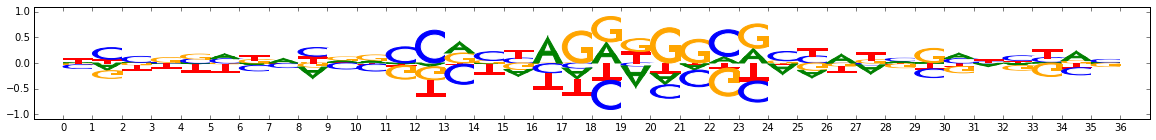

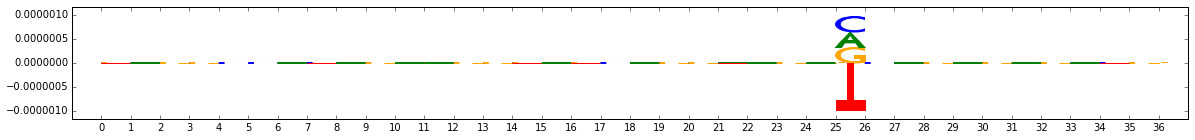

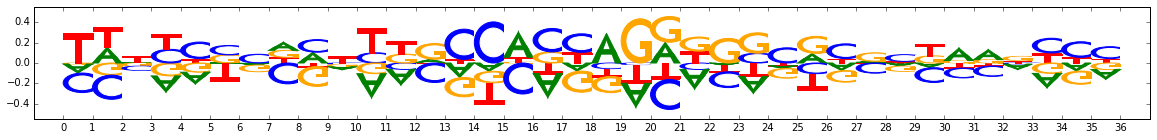

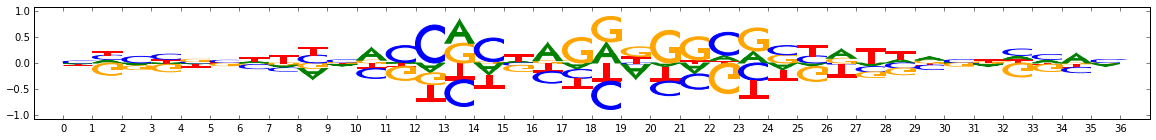

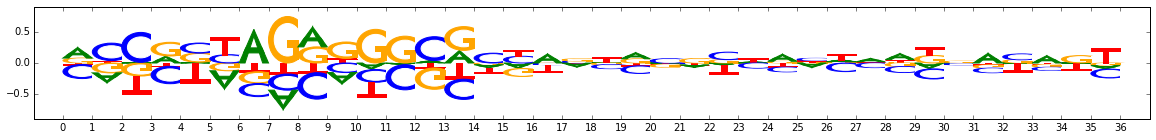

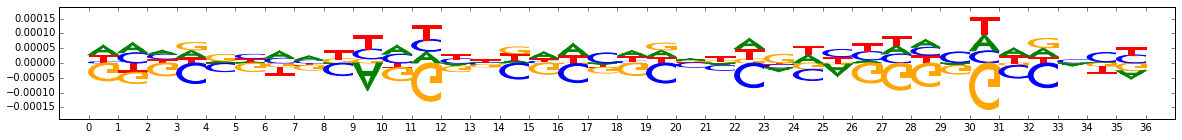

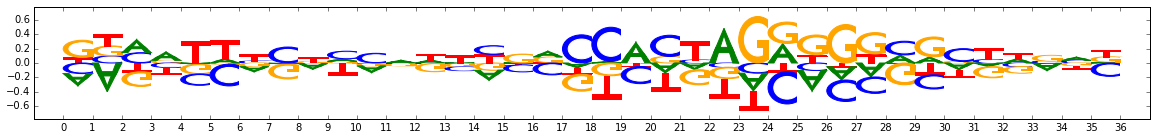

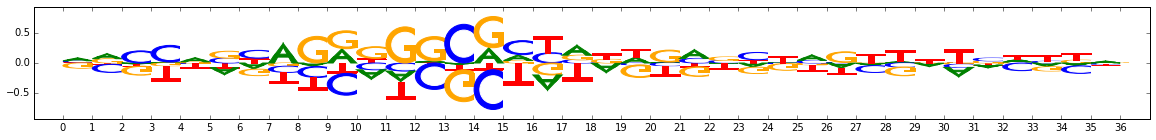

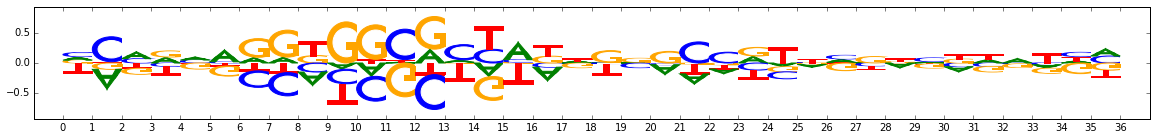

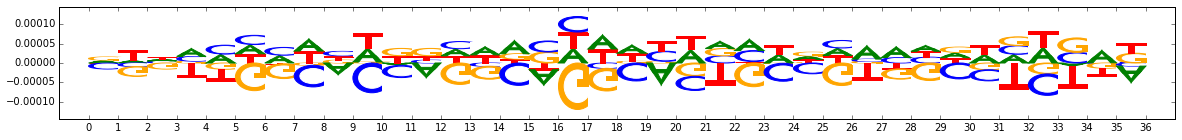

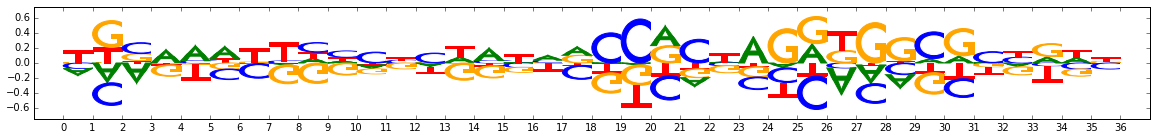

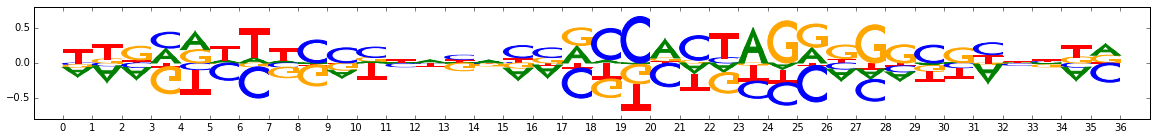

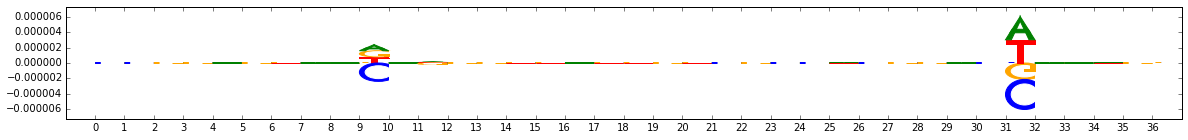

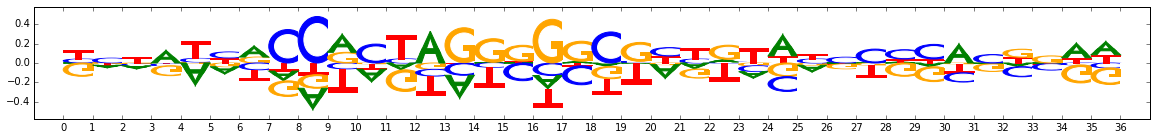

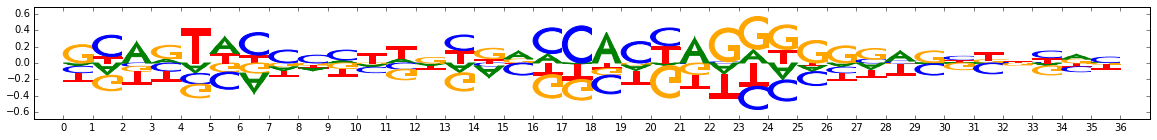

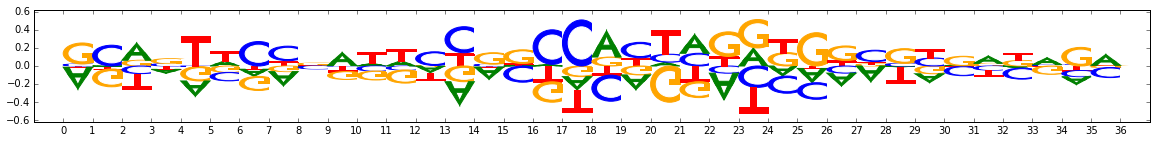

In [34]:
reshaped_arr = arr.reshape(36,4,16)
reshaped_arr = reshaped_arr.transpose(2,0,1)
for i in range(16):
    viz_sequence.plot_weights((reshaped_arr[i]
                               -np.mean(reshaped_arr[i],axis=1)[:,None]))